In [ ]:
!pip install ucimlrepo


# Import & Load Data

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

# Load dataset
air_quality = fetch_ucirepo(id=360)

# All data is in .features (NO targets table)
df = air_quality.data.features

print(df.head())
print(df.info())

print("Columns:", df.columns.tolist())


        Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  3/10/2004  18:00:00     2.6         1360       150      11.9   
1  3/10/2004  19:00:00     2.0         1292       112       9.4   
2  3/10/2004  20:00:00     2.2         1402        88       9.0   
3  3/10/2004  21:00:00     2.2         1376        80       9.2   
4  3/10/2004  22:00:00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4 

# Select Features + Target

In [ ]:
# Remove non-numerical columns
df = df.drop(columns=["Date", "Time"])

# Define target variable
target_col = "CO(GT)"     # Predict CO as AQI proxy

# Features = all except target
X = df.drop(columns=[target_col])
y = df[target_col]



# Clean Missing Values

In [ ]:
# Replace -200 with NaN
X = X.replace(-200, np.nan)
y = y.replace(-200, np.nan)

# Drop rows with missing values
data = pd.concat([X, y], axis=1).dropna()

X = data[X.columns]
y = data[target_col]


# Train/Test Split & Scaling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Build ANN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

# Training (with EarlyStopping)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 7.7835 - root_mean_squared_error: 2.7884 - val_loss: 5.2235 - val_root_mean_squared_error: 2.2855
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4696 - root_mean_squared_error: 2.3371 - val_loss: 3.1819 - val_root_mean_squared_error: 1.7838
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8102 - root_mean_squared_error: 1.6746 - val_loss: 1.1292 - val_root_mean_squared_error: 1.0626
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9273 - root_mean_squared_error: 0.9613 - val_loss: 0.5660 - val_root_mean_squared_error: 0.7523
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6289 - root_mean_squared_error: 0.7929 - val_loss: 0.4418 - val_root_mean_squared_error: 0.6646
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4193 - root_mean_squared_error: 0.6467 - val_loss: 0.2934 - val_root_mean_squared_error: 0.5417
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2897 - 

# Evaluation



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np # Import numpy for sqrt

y_pred = model.predict(X_test_scaled).flatten()

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Calculate RMSE from MSE
r2 = r2_score(y_test, y_pred)

print("Test RMSE:", rmse)
print("Test R²:", r2)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Test RMSE: 0.2228688527998822
Test R²: 0.9761388274260692


# Plots

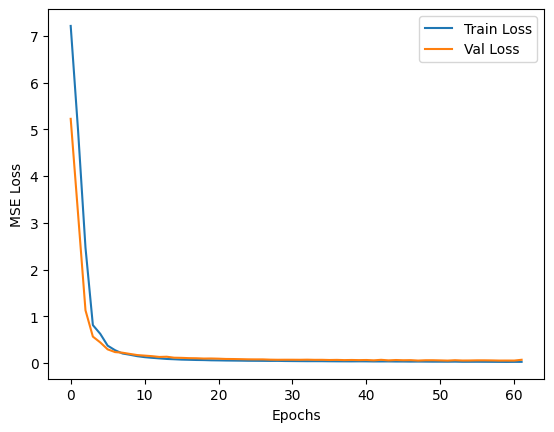

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


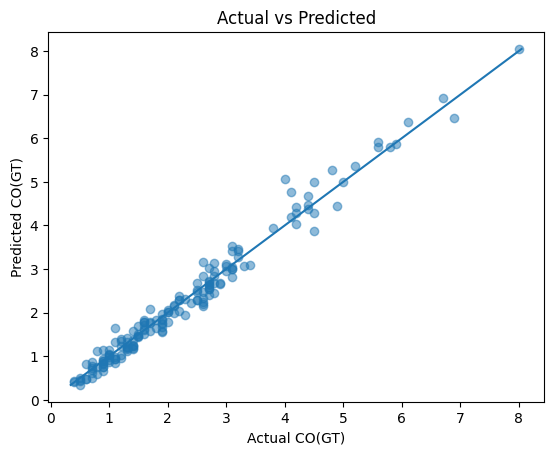

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual CO(GT)")
plt.ylabel("Predicted CO(GT)")
plt.title("Actual vs Predicted")
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims)
plt.show()
